In [1]:
import pandas as pd
import nfl_data_py as nfl

In [2]:
# df = pd.read_pickle('2013-2023_plays.pkl')

In [3]:
# df_fg = df[df['field_goal_attempt']==1]

In [4]:
# # df_fg['play_duration'] = 
# df_fg[['time','drive_game_clock_end']]

# df_fg['drive_game_clock_end'] = pd.to_datetime(df_fg['drive_game_clock_end'], format='%M:%S')
# df_fg['time'] = pd.to_datetime(df_fg['time'], format='%M:%S')


# df_fg['play_time'] = (df_fg['time']-df_fg['drive_game_clock_end']).dt.seconds

# df_fg['play_time'].mode()


In [5]:
class GameState:
    def __init__(self, **kwargs):
        self.receive_2h_ko = self._validate_receive_2h_ko(kwargs.get('receive_2h_ko', 0))
        self.home_team = self._validate_home_team(kwargs.get('home_team', ""))
        self.posteam = self._validate_posteam(kwargs.get('posteam', ""))
        self.score_differential = self._validate_score_differential(kwargs.get('score_differential', 0))
        self.half_seconds_remaining = self._validate_half_seconds_remaining(kwargs.get('half_seconds_remaining', 1800))
        self.game_seconds_remaining = self._validate_game_seconds_remaining(kwargs.get('game_seconds_remaining', 3600))
        self.spread_line = self._validate_spread_line(kwargs.get('spread_line', [1, 3, 4, 7, 14]))
        self.down = self._validate_down(kwargs.get('down', 1))
        self.ydstogo = self._validate_ydstogo(kwargs.get('ydstogo', 10))
        self.yardline_100 = self._validate_yardline_100(kwargs.get('yardline_100', 75))
        self.posteam_timeouts_remaining = self._validate_timeouts(kwargs.get('posteam_timeouts_remaining', 3))
        self.defteam_timeouts_remaining = self._validate_timeouts(kwargs.get('defteam_timeouts_remaining', 3))
        self.goal_to_go = self._validate_goal_to_go(kwargs.get('goal_to_go',0))

    def update_attribute(self, attribute, value):
        if hasattr(self, attribute):
            validation_method = getattr(self, f'_validate_{attribute}')
            setattr(self, attribute, validation_method(value))
        else:
            raise AttributeError(f"GameState has no attribute '{attribute}'")

    def _validate_receive_2h_ko(self, value):
        if value not in [0, 1]:
            raise ValueError("receive_2h_ko must be either 0 or 1")
        return value

    def _validate_posteam(self, value):
        if not isinstance(value, str) or len(value) < 1 or len(value) > 4:
            raise ValueError("home_team and posteam must be a string with length between 1 and 4")
        return value
    
    def _validate_home_team(self, value):
        if not isinstance(value, str) or len(value) < 1 or len(value) > 4:
            raise ValueError("home_team and posteam must be a string with length between 1 and 4")
        return value

    def _validate_score_differential(self, value):
        if not isinstance(value, int):
            raise ValueError("score_differential must be an integer")
        return value

    def _validate_game_seconds_remaining(self, value):
        if not isinstance(value, int) or value < 0:
            raise ValueError("half_seconds_remaining and game_seconds_remaining must be non-negative integers")
        return value

    def _validate_spread_line(self, value):
        if not isinstance(value, int):
            raise ValueError("spread_line must be an integer")
        return value

    def _validate_down(self, value):
        if not isinstance(value, int) or value < 1 or value > 4:
            raise ValueError("down must be an integer between 1 and 4")
        return value

    def _validate_ydstogo(self, value):
        if not isinstance(value, int) or value < 1 or value > 99:
            raise ValueError("ydstogo must be an integer between 1 and 99")
        return value

    def _validate_yardline_100(self, value):
        if not isinstance(value, int) or value < 1 or value > 99:
            raise ValueError("yardline_100 must be an integer between 1 and 99")
        return value

    def _validate_timeouts(self, value):
        if not isinstance(value, int) or value < 0 or value > 3:
            raise ValueError("posteam_timeouts_remaining and defteam_timeouts_remaining must be integers between 0 and 3")
        return value

    def _validate_goal_to_go (self, value):
        if value not in [0, 1]:
            raise ValueError("goal_to_go must be either 0 or 1")
        return value
    
    def _validate_half_seconds_remaining(self, value):
        if not isinstance(value, int) or value < 0:
            raise ValueError("half_seconds_remaining must be a non-negative integer")
        return value
    



    def __str__(self):
        return f"GameState(receive_2h_ko={self.receive_2h_ko}, home_team='{self.home_team}', " \
               f"posteam='{self.posteam}', score_differential={self.score_differential}, " \
               f"half_seconds_remaining={self.half_seconds_remaining}, " \
               f"game_seconds_remaining={self.game_seconds_remaining}, spread_line={self.spread_line}, " \
               f"down={self.down}, ydstogo={self.ydstogo}, yardline_100={self.yardline_100}, " \
               f"posteam_timeouts_remaining={self.posteam_timeouts_remaining}, " \
               f"defteam_timeouts_remaining={self.defteam_timeouts_remaining}, "\
               f"goal_to_go={self.goal_to_go})"

In [6]:
def fg_made(game_state):
    if game_state.half_seconds_remaining <5:
        game_state.update_attribute('game_seconds_remaining',game_state.game_seconds_remaining - game_state.half_seconds_remaining)
        game_state.update_attribute('half_seconds_remaining',0)
    else:
        game_state.update_attribute('half_seconds_remaining',game_state.half_seconds_remaining-5)
        game_state.update_attribute('game_seconds_remaining',game_state.game_seconds_remaining-5)

    game_state.update_attribute('score_differential',-(game_state.score_differential+3))

    if game_state.home_team == game_state.posteam:
        game_state.update_attribute('posteam','xxx')
    else:
        game_state.update_attribute('posteam',game_state.home_team)
        
    game_state.update_attribute('yardline_100',75)
    game_state.update_attribute('down',1)
    game_state.update_attribute('ydstogo',10)

    game_state.update_attribute('goal_to_go',0)


In [7]:
def fg_miss(game_state):
    if game_state.half_seconds_remaining <5:
        game_state.update_attribute('game_seconds_remaining',game_state.game_seconds_remaining - game_state.half_seconds_remaining)
        game_state.update_attribute('half_seconds_remaining',0)
    else:
        game_state.update_attribute('half_seconds_remaining',game_state.half_seconds_remaining-5)
        game_state.update_attribute('game_seconds_remaining',game_state.game_seconds_remaining-5)


    if game_state.home_team == game_state.posteam:
        game_state.update_attribute('posteam','xxx')
    else:
        game_state.update_attribute('posteam',game_state.home_team)
    predicted_line = 100-(game_state.yardline_100+7)
    if predicted_line > 99:
        game_state.update_attribute('yardline_100',99)
    elif predicted_line < 1:
         game_state.update_attribute('yardline_100',1)
    else:
        game_state.update_attribute('yardline_100',100-(game_state.yardline_100+7))
    game_state.update_attribute('down',1)
    game_state.update_attribute('ydstogo',10)

    game_state.update_attribute('goal_to_go',0)


In [8]:
import pickle
def punt(game_state):
    if game_state.half_seconds_remaining <5:
        game_state.update_attribute('game_seconds_remaining',game_state.game_seconds_remaining - game_state.half_seconds_remaining)
        game_state.update_attribute('half_seconds_remaining',0)
    else:
        game_state.update_attribute('half_seconds_remaining',game_state.half_seconds_remaining-5)
        game_state.update_attribute('game_seconds_remaining',game_state.game_seconds_remaining-5)

    if game_state.home_team == game_state.posteam:
        game_state.update_attribute('posteam','xxx')
    else:
        game_state.update_attribute('posteam',game_state.home_team)
    
    with open('punt_yardage_model.pkl', 'rb') as file:
        # Punt Model predicts new yard line given current yard line
        punt_model = pickle.load(file)

    with open('punt_touchback_model.pkl', 'rb') as file:
        punt_touchback_model = pickle.load(file)
    
    if punt_touchback_model.predict_proba([[game_state.yardline_100]])[0][1] > 0.5:
        game_state.update_attribute('yardline_100',80)

    else:
        game_state.update_attribute('yardline_100',round(punt_model.predict([[game_state.yardline_100]])[0]))

    game_state.update_attribute('down',1)
    game_state.update_attribute('ydstogo',10)

In [9]:
def go_for_it_fail(game_state):
    if game_state.half_seconds_remaining <5:
        game_state.update_attribute('game_seconds_remaining',game_state.game_seconds_remaining - game_state.half_seconds_remaining)
        game_state.update_attribute('half_seconds_remaining',0)
    else:
        game_state.update_attribute('half_seconds_remaining',game_state.half_seconds_remaining-5)
        game_state.update_attribute('game_seconds_remaining',game_state.game_seconds_remaining-5)

    if game_state.home_team == game_state.posteam:
        game_state.update_attribute('posteam','xxx')
    else:
        game_state.update_attribute('posteam',game_state.home_team)

    with open('GFI_fail_model.pkl', 'rb') as file:
    # GFI Model predicts  yard gain/loss given current game state
        GFI_fail_model = pickle.load(file)

    predicted_line = 100-(game_state.yardline_100 - GFI_fail_model.predict([[game_state.yardline_100,game_state.ydstogo,game_state.goal_to_go]])[0])
    
    if predicted_line >99:
        game_state.update_attribute('yardline_100',99)
    elif predicted_line < 1:
         game_state.update_attribute('yardline_100',1)
            
    else:
        game_state.update_attribute('yardline_100',round(predicted_line))

    game_state.update_attribute('down',1)
    game_state.update_attribute('ydstogo',10)


In [10]:

def go_for_it_success(game_state):
    if game_state.half_seconds_remaining <5:
        game_state.update_attribute('game_seconds_remaining',game_state.game_seconds_remaining - game_state.half_seconds_remaining)
        game_state.update_attribute('half_seconds_remaining',0)
    else:
        game_state.update_attribute('half_seconds_remaining',game_state.half_seconds_remaining-5)
        game_state.update_attribute('game_seconds_remaining',game_state.game_seconds_remaining-5)


    if game_state.goal_to_go ==1:
        game_state.update_attribute('score_differential',-(game_state.score_differential+7))
        # New yardage after kickoff
        game_state.update_attribute('yardline_100',75)
        game_state.update_attribute('down',1)
        game_state.update_attribute('ydstogo',10)
        game_state.update_attribute('goal_to_go',0)
    else:
        with open('GFI_success.pkl', 'rb') as file:
            # GFI Model predicts  yard gain/loss given current game state
            GFI_success_model = pickle.load(file)
        predicted_line =game_state.yardline_100 -  GFI_success_model.predict([[game_state.yardline_100,game_state.ydstogo]])[0]
        if predicted_line >= game_state.yardline_100:
            game_state.update_attribute('yardline_100',1)
        # if predicted_line <1:
        #     game_state.update_attribute('yardline_100',1)
        # if predicted_line > 99:
        #     game_state.update_attribute('yardline_100',99)
        else:
            game_state.update_attribute('yardline_100',(game_state.yardline_100 - round(predicted_line)))
        
    
        

In [11]:
import pandas as pd

def create_game_states():
    game_states_data = []
    game_states_list = [] #also generate game state class objects

    for yardline_100 in range(1, 100):
        for ydstogo in range(1, 11):
            goal_to_go = 1 if yardline_100 <= 10 else 0

            game_state_data = {
                'receive_2h_ko': 1,
                'home_team': "SEA",
                'posteam': "SEA",
                'score_differential': 0,
                'half_seconds_remaining': 900,
                'game_seconds_remaining': 2700,
                'spread_line': -3,
                'down': 4,
                'ydstogo': ydstogo,
                'yardline_100': yardline_100,
                'posteam_timeouts_remaining': 3,
                'defteam_timeouts_remaining': 3,
                'goal_to_go': goal_to_go
            }

            game_states_data.append(game_state_data)
            game_states_list.append(GameState(**game_state_data))

    game_states_df = pd.DataFrame(game_states_data)
    return game_states_df,game_states_list

In [12]:
game_states,game_state_list = create_game_states()

In [13]:
for game_state in game_states:
    print(game_state)

receive_2h_ko
home_team
posteam
score_differential
half_seconds_remaining
game_seconds_remaining
spread_line
down
ydstogo
yardline_100
posteam_timeouts_remaining
defteam_timeouts_remaining
goal_to_go


In [14]:
# game_states
game_state_list

In [15]:
import copy
test = copy.deepcopy(game_state_list[0])

print(game_state_list[0])

GameState(receive_2h_ko=1, home_team='SEA', posteam='SEA', score_differential=0, half_seconds_remaining=900, game_seconds_remaining=2700, spread_line=-3, down=4, ydstogo=1, yardline_100=1, posteam_timeouts_remaining=3, defteam_timeouts_remaining=3, goal_to_go=1)


In [16]:
print(test)

GameState(receive_2h_ko=1, home_team='SEA', posteam='SEA', score_differential=0, half_seconds_remaining=900, game_seconds_remaining=2700, spread_line=-3, down=4, ydstogo=1, yardline_100=1, posteam_timeouts_remaining=3, defteam_timeouts_remaining=3, goal_to_go=1)


In [17]:
(fg_made(test))
print(test)

GameState(receive_2h_ko=1, home_team='SEA', posteam='xxx', score_differential=-3, half_seconds_remaining=895, game_seconds_remaining=2695, spread_line=-3, down=1, ydstogo=10, yardline_100=75, posteam_timeouts_remaining=3, defteam_timeouts_remaining=3, goal_to_go=0)


In [18]:
potential_states_dict = {}

for game_state in game_state_list:
    game_state_punt = copy.deepcopy(game_state)
    game_state_FG_made = copy.deepcopy(game_state)
    game_state_FG_miss = copy.deepcopy(game_state)
    game_state_GFI_fail = copy.deepcopy(game_state)
    game_state_GFI_success = copy.deepcopy(game_state)

    punt(game_state_punt)
    fg_made(game_state_FG_made)
    fg_miss(game_state_FG_miss)
    go_for_it_fail(game_state_GFI_fail)
    go_for_it_success(game_state_GFI_success)


    potential_states = {
        "Punt": game_state_punt,
        "FG_SUCCESS": game_state_FG_made,
        "FG_FAIL": game_state_FG_miss,
        "GFI_FAIL": game_state_GFI_fail,
        "GFI_SUCCESS": game_state_GFI_success
    }
    potential_states_dict[game_state] = potential_states

/Users/ilanb/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/ilanb/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/ilanb/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/ilanb/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/ilanb/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/ilanb/anaconda3/lib/

In [19]:
with open('my_dict.pkl', 'wb') as file:
    # Pickle the dictionary and write it to the file
    pickle.dump(potential_states_dict, file)

In [20]:
with open('my_class.pkl', 'wb') as file:
    pickle.dump(GameState, file)

In [21]:
# R Stuff
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.packages import importr

# Activate the conversion between pandas and R data frames
pandas2ri.activate()
nflfastr = importr('nflfastR')
dplyr = importr('dplyr')

# def calculate_win_probability(game_state_dict):
#     with localconverter(robjects.default_converter + pandas2ri.converter):
#         r_data_frame = robjects.DataFrame(game_state_dict)
    
#     # Calculate the win probability using the nflfastR function
#     wp_data = dplyr.select(nflfastr.calculate_win_probability(r_data_frame), "spread_line", "wp", "vegas_wp")
    
#     return wp_data[2]  # Return the 'wp' value

# # Get the attribute names of the GameState class
# game_state_attrs = [attr for attr in dir(GameState) if not attr.startswith('__') and not callable(getattr(GameState, attr))]

# # Calculate the win probability for each 2nd layer state
# wp_dict = {}
# for game_state, game_state_data in potential_states_dict.items():
#     wp_dict[game_state] = {}
#     for state_name, state_data in game_state_data.items():
#         state_dict = dict(zip(game_state_attrs, state_data))
#         wp = calculate_win_probability(state_dict)
#         wp_dict[game_state][f"{state_name}_wp"] = wp

# # Update the original potential_states_dict with win probabilities
# for game_state, game_state_data in potential_states_dict.items():
#     game_state_data.update(wp_dict[game_state])

# # Print the updated potential_states_dict
# print(potential_states_dict)

In [22]:
def calculate_win_probability(game_state_dict):
    with localconverter(robjects.default_converter + pandas2ri.converter):
        r_data_frame = robjects.DataFrame(game_state_dict)
    
    # Calculate the win probability using the nflfastR function
    wp_data = dplyr.select(nflfastr.calculate_win_probability(r_data_frame), "spread_line", "wp", "vegas_wp")
    
    return wp_data

def calculate_all_win_probabilities(game_states_dict):
    results = {}
    for initial_state, outcomes in game_states_dict.items():
        outcome_results = {}
        for outcome, state in outcomes.items():
            if isinstance(state, GameState):  # Check if it's a GameState instance
                state_dict = state.__dict__  # Convert GameState to dictionary
                wp_data = calculate_win_probability(state_dict)
                outcome_results[outcome] = wp_data[2]  # Assuming wp_data[2] contains the win probability
        results[initial_state] = outcome_results
    return results

# Assuming your initial dictionary is named `game_states_dict`
all_probabilities = calculate_all_win_probabilities(potential_states_dict)

# Now print or process `all_probabilities` as needed
for state, probs in all_probabilities.items():
    print(f"GameState ID: {id(state)}")
    for outcome, prob in probs.items():
        print(f"{outcome}: {prob}")


[13:24:40] WARNING: src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[13:24:40] WARNING: src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

GameState ID: 4948166032
Punt: [0.61034167]
FG_SUCCESS: [0.52636594]
FG_FAIL: [0.59941709]
GFI_FAIL: [0.58001703]
GFI_SUCCESS: [0.24368742]
GameState ID: 46

In [23]:


# # Create a single GameState object called test
# test = GameState(
#     receive_2h_ko=0,
#     home_team="SEA",
#     posteam="SEA",
#     score_differential=0,
#     half_seconds_remaining=1800,
#     game_seconds_remaining=3600,
#     spread_line=-3,
#     down=1,
#     ydstogo=10,
#     yardline_100=75,
#     posteam_timeouts_remaining=3,
#     defteam_timeouts_remaining=3
# )

# # Convert the test game state to a dictionary representation
# test_dict = test.__dict__

# # Calculate the win probability for the test game state
# wp_data = calculate_win_probability(test_dict)

# # Print the win probability data
# print(wp_data[2])

In [24]:
# def create_probabilities_mapping(game_states_dict):
#     results = {}
#     for initial_state, outcomes in game_states_dict.items():
#         outcome_results = {}
#         for outcome, state in outcomes.items():
#             if isinstance(state, GameState):  # Check if it's a GameState instance
#                 state_dict = state.__dict__  # Convert GameState to dictionary
#                 wp_data = calculate_win_probability(state_dict)
#                 # Create a structured result with the state and its probability
#                 outcome_results[outcome] = {'state': state, 'probability': wp_data[2]}
#         results[initial_state] = outcome_results
#     return results

# # Assuming your initial dictionary is named `potential_states_dict`
# new_probabilities_dict = create_probabilities_mapping(potential_states_dict)

# # Now `new_probabilities_dict` contains the original GameState objects and their calculated probabilities


In [25]:
first_key, first_value = next(iter(all_probabilities.items()))

# Print the first key and value
print("First GameState:", first_key)
print("Outcomes and probabilities:", first_value)

First GameState: GameState(receive_2h_ko=1, home_team='SEA', posteam='SEA', score_differential=0, half_seconds_remaining=900, game_seconds_remaining=2700, spread_line=-3, down=4, ydstogo=1, yardline_100=1, posteam_timeouts_remaining=3, defteam_timeouts_remaining=3, goal_to_go=1)
Outcomes and probabilities: {'Punt': array([0.61034167]), 'FG_SUCCESS': array([0.52636594]), 'FG_FAIL': array([0.59941709]), 'GFI_FAIL': array([0.58001703]), 'GFI_SUCCESS': array([0.24368742])}


In [26]:
for game_state, outcomes in all_probabilities.items():
    for outcome, probability_array in outcomes.items():
        if outcome in ['Punt', 'FG_SUCCESS', 'FG_FAIL', 'GFI_FAIL']:
            # Flip the probability
            outcomes[outcome] = 1 - probability_array

        elif outcome == 'GFI_SUCCESS':
            # Check if `goal_to_go` is not zero in the GameState object linked to this outcome
            if game_state.goal_to_go != 0:
                # Flip the probability
                outcomes[outcome] = 1 - probability_array


In [27]:
first_key, first_value = next(iter(all_probabilities.items()))

# Print the first key and value
print("First GameState:", first_key)
print("Outcomes and probabilities:", first_value)

First GameState: GameState(receive_2h_ko=1, home_team='SEA', posteam='SEA', score_differential=0, half_seconds_remaining=900, game_seconds_remaining=2700, spread_line=-3, down=4, ydstogo=1, yardline_100=1, posteam_timeouts_remaining=3, defteam_timeouts_remaining=3, goal_to_go=1)
Outcomes and probabilities: {'Punt': array([0.38965833]), 'FG_SUCCESS': array([0.47363406]), 'FG_FAIL': array([0.40058291]), 'GFI_FAIL': array([0.41998297]), 'GFI_SUCCESS': array([0.75631258])}


In [28]:
import pickle
with open('fg_model.pkl', 'rb') as file:
    fg_model = pickle.load(file)

import pickle
with open('GFI_prediction_model.pkl', 'rb') as file:
    GFI_model = pickle.load(file)


In [40]:
GFI_model.predict_proba([[4]])[0][1]

/Users/ilanb/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0.45860792397665373

In [46]:
for game_state, outcomes in all_probabilities.items():
    if hasattr(game_state, 'yardline_100') and hasattr(game_state, 'ydstogo'):
        # Compute FG_percentage
        FG_percentage = fg_model.predict_proba([[game_state.yardline_100 + 7]])[0][1]

        # Compute GFI_percentage
        GFI_percentage = GFI_model.predict_proba([[game_state.ydstogo]])[0][1]

        # Add these metrics to the dictionary
        outcomes['FG_percentage'] = FG_percentage
        outcomes['GFI_percentage'] = GFI_percentage
    else:
        print(f"GameState object {game_state.ydstogo} is missing required attributes.")


/Users/ilanb/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/ilanb/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/ilanb/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/ilanb/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/ilanb/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/ilanb/anaconda3/lib/

In [48]:
# all_probabilities

def calculate_gfi_wp(gfi_fail, gfi_success, gfi_percentage):
    return gfi_fail * (1 - gfi_percentage) + gfi_success * gfi_percentage

def calculate_fg_wp(fg_success, fg_fail, fg_percentage):
    return fg_success * fg_percentage + fg_fail * (1 - fg_percentage)


In [63]:
import numpy as np
for game_state, outcomes in all_probabilities.items():
    # Extract the necessary values from the dictionary
    gfi_fail = outcomes['GFI_FAIL'][0]
    gfi_success = outcomes['GFI_SUCCESS'][0]
    fg_success = outcomes['FG_SUCCESS'][0]
    fg_fail = outcomes['FG_FAIL'][0]
    punt_wp = outcomes['Punt'][0]
    
    # Retrieve percentages from the dictionary
    gfi_percentage = outcomes['GFI_percentage']
    fg_percentage = outcomes['FG_percentage']
    
    # Calculate win probabilities for each decision
    gfi_wp = calculate_gfi_wp(gfi_fail, gfi_success, gfi_percentage)
    fg_wp = calculate_fg_wp(fg_success, fg_fail, fg_percentage)
    
    # Punt win probability (directly use the Punt value as its win probability)
    punt_wp = punt_wp  # Assuming `Punt` already contains a probability value
    
    # Determine the best decision
    decisions = np.array([punt_wp, fg_wp, gfi_wp])
    decision_names = np.array(['Punt', 'FG', 'GFI'])
    optimal_decision = decision_names[np.argmax(decisions)]
    
    # Add the recommendation to the dictionary
    outcomes['recommendation'] = optimal_decision


In [65]:
game_state, outcomes = next(iter(all_probabilities.items()))


print(game_state)

GameState(receive_2h_ko=1, home_team='SEA', posteam='SEA', score_differential=0, half_seconds_remaining=900, game_seconds_remaining=2700, spread_line=-3, down=4, ydstogo=1, yardline_100=1, posteam_timeouts_remaining=3, defteam_timeouts_remaining=3, goal_to_go=1)


In [106]:
import numpy as np

# Define the grid size
max_yardline = 99
max_yds_to_go = 10

# Initialize the matrix
recommendation_matrix = np.full((max_yds_to_go, max_yardline), None, dtype=object)


In [123]:
for game_state, outcomes in all_probabilities.items():
    # Extract yardline and yds_to_go from each game state
    if hasattr(game_state, 'yardline_100') and hasattr(game_state, 'ydstogo'):
        yardline_100 = game_state.yardline_100
        ydstogo = game_state.ydstogo

        # Check for the specific condition to override with "Punt"
        if ydstogo > 5 and yardline_100 > 70:
            recommendation = 'Punt'  # Force the recommendation to be "Punt"
        # if ydstogo > 5 and yardline_100 > 72:
        #     recommendation = 'Punt'  # Force the recommendation to be "Punt"
        else:
            # Otherwise, use the pre-calculated recommendation
            recommendation = outcomes.get('recommendation', 'Punt')  # Default to 'Punt' if not found

        # Validate that the indices are within the expected range
        if 1 <= yardline_100 <= max_yardline and 1 <= ydstogo <= max_yds_to_go:
            # Populate the matrix (adjust indices since Python uses 0-based indexing)
            recommendation_matrix[ydstogo - 1, yardline_100 - 1] = recommendation
        else:
            print(f"Out of range values: yardline_100={yardline_100}, ydstogo={ydstogo}")
    else:
        print(f"Missing attributes in GameState object {game_state}")

# After populating the matrix, print it or proceed with further analysis
print(recommendation_matrix)


[['GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'FG' 'FG'
  'FG' 'FG' 'FG' 'FG' 'FG' 'FG' 'FG' 'FG' 'GFI' 'FG' 'FG' 'GFI' 'GFI'
  'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI'
  'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI'
  'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI'
  'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI'
  'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI'
  'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI'
  'GFI' 'GFI']
 ['GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'FG' 'FG'
  'FG' 'FG' 'FG' 'FG' 'FG' 'FG' 'FG' 'FG' 'FG' 'FG' 'FG' 'FG' 'FG' 'FG'
  'FG' 'FG' 'FG' 'FG' 'FG' 'FG' 'FG' 'FG' 'FG' 'FG' 'FG' 'FG' 'FG' 'FG'
  'FG' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI'
  'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI'
  'GFI' 'GFI' 'GFI' 'GFI' 'GFI' 'GFI

In [124]:
# Create a mapping dictionary
label_to_int = {'GFI': 0, 'FG': 1, 'Punt': 2}

# Convert your matrix of labels to a matrix of integers
int_matrix = np.array([[label_to_int[item] for item in row] for row in recommendation_matrix])


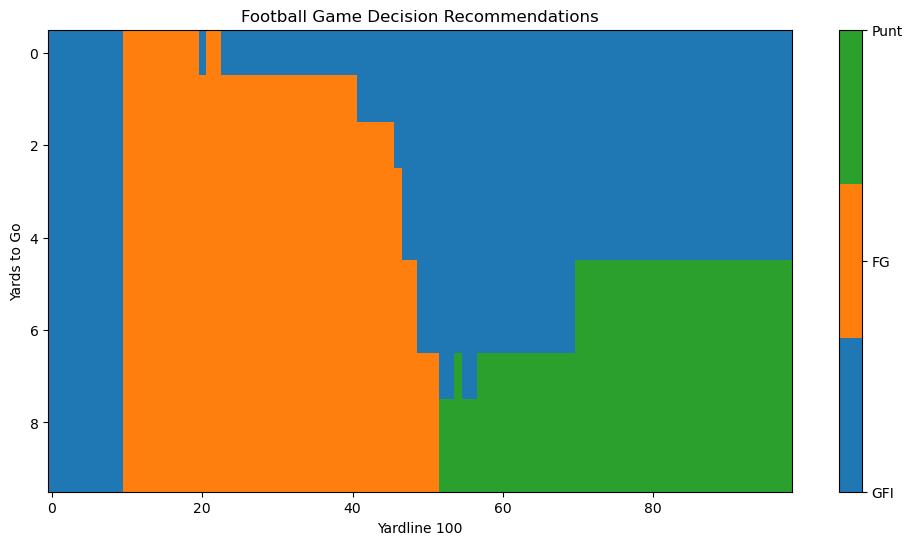

In [125]:
import matplotlib.pyplot as plt

# Define the size of the plot
plt.figure(figsize=(12, 6))

# Create a custom colormap
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['#1f77b4', '#ff7f0e', '#2ca02c'])  # Blue for GFI, Orange for FG, Green for Punt

# Plot the matrix
plt.imshow(int_matrix, cmap=cmap, aspect='auto')

# Add a color bar with labels
cbar = plt.colorbar(ticks=[0, 1, 2])
cbar.ax.set_yticklabels(['GFI', 'FG', 'Punt'])  # vertically oriented colorbar

# Adding labels for axes
plt.xlabel('Yardline 100')
plt.ylabel('Yards to Go')

# Adding title
plt.title('Football Game Decision Recommendations')

# Display the plot
plt.show()
